# The Basics of Book Bias
## Analyzing trends of bestselling books on different platforms
Gesna Aggarwal, Brendan DeMilt, Lydia Hu

Contents:  
 - ### [Data Gathering](#Part-1:-Data-Gathering)  
 - ### [Data Cleaning and Management](#Part-2:-Data-Cleaning-and-Management)  
 - ### [Data Analysis](#Part-3:-Data-Analysis)  
 - ### [Hypothesis Testing and ML](#Part-4:-Hypothesis-Testing-and-ML)  

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from google.colab import drive
#from google.colab import files

# Part 1: Data Gathering

## New York Times API - Data Extraction and Compilation  

Our team used the New York Times Book API. This API provides information about book reviews and The New York Times Best Sellers lists.

According to the New York Time's [website](https://www.nytimes.com/books/best-sellers/methodology/),  

> "The (bestseller) rankings reflect unit sales reported on a confidential basis by vendors offering a wide range of general interest titles published in the United States. Every week, thousands of diverse selling locations report their actual sales on hundreds of thousands of individual titles. The panel of reporting retailers is comprehensive and reflects sales in tens of thousands of stores of all sizes and demographics across the United States."

In order to get the bestseller data, there were several steps in the process 

1.   Our team had to register an account with the New York Times to get a key to access the data. 
2.  We created a function that returned a list of all the dates in 2018 in "YYYY-MM-DD" format. This is the format the Book API takes in date data. 
3. The New York Times has bestsellers in 61 different categories. In order to narrow down the data that we analyze, we chose the two most general categories from this list. Namely - ***Combined print and e-book fiction*** and  ***Combined print and e-book non-fiction***
4. API calls were made for each day of 2018 for these two categories. All the data returned by the New York Times API is in the JSON format. This data was converted into a pandas dataframe and concatenated into one unified dataframe. 
5. According to the guidelines for using the New York Times API, you can only make one API call every 6 seconds. Thus, creating this dataframe took a total of 73 minutes. 
6. Once the dataframe was created, we were able to store it in the form of a CSV file. This CSV file is what we will be using for the rest of the analysis. 


In [0]:
nyt_key = "QKADCGTZwzGLGNw0ANu79NoNHAvAE5m3"

#returns a list of all dates in 2018 in the YYYY-MM-DD format to pass into the New York Times API 
def get2018Dates(): 
  allDates = [] 
  for i in range(1, 13):
    if i == 1 or i == 3 or i == 5 or i == 7 or i == 8 or i == 10 or i == 12: 
      for j in range(1, 32): 
        allDates.append("2018-" + str('%02d' % i) + "-" + str ('%02d' % j))
    if i == 2: 
      for j in range(1, 29): 
        allDates.append("2018-" + str('%02d' % i) + "-" + str ('%02d' % j))
    if i == 4 or i == 6 or i == 9 or i == 11: 
      for j in range(1, 31): 
        allDates.append("2018-" + str('%02d' % i) + "-" + str ('%02d' % j))
  return allDates

#get the type of books featured in the bestseller category for New York Times 
getTypesOfBooks = requests.get('https://api.nytimes.com/svc/books/v3/lists/names.json?api-key='+nyt_key)
nyt_data = pd.DataFrame.from_dict(getTypesOfBooks.json()['results'])
typesOfBooks = [] 
typesOfBooks.append(nyt_data.list_name_encoded.unique()[0])
typesOfBooks.append(nyt_data.list_name_encoded.unique()[1])

#get all data for all books in 2018 and compile it into one dataset 
all2018Dates = get2018Dates()
finalDataFrame = pd.DataFrame()

for date in all2018Dates: 
  for bookType in typesOfBooks: 
    apiCall = requests.get('https://api.nytimes.com/svc/books/v3/lists/' + 
                           bookType + '/' + date + '.json?api-key=' + nyt_key) 
    time.sleep(6)
    if 'results' in apiCall.json(): 
      test3 = apiCall.json()['results']
      dataFrame = pd.DataFrame(test3['books'])
      dataFrame['date'] = date
      dataFrame['typeOfBook'] = bookType
      finalDataFrame = pd.concat([dataFrame, finalDataFrame])


In [5]:
#Mounting google drive to google collaboratory and exporting the pandas dataframe to google drive as a .csv file 
drive.mount('drive')
finalDataFrame.to_csv('data2.csv')
!cp data2.csv drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [6]:
#uploading the csv file to google colab 
uploaded = files.upload()

Saving data2.csv to data2 (1).csv


## Goodreads API
Goodreads is a social website for readers owned by Amazon, allowing them to track, organize, rate, and interact with friends and authors to collaborate in groups and lists to discuss books. So addition to expected data about books (ISBN, publication date), Goodreads contains data about how readers of a book interact with each other. Goodreads is different from Amazon, NYT, and publishers' sites because it crowdsources some of its information. For instance, the genre of a book depends on how users personally categorize the book in their shelves. Goodreads also allows readers to add metadata about a book (some subjective), for instance, its tone, pace, literary devices used. 

Goodreads uses its own book IDs in addition to having ISBNs. Some of the categorization ambiguities with this system are that different editions of a book will have different ISBNs, like a collector's edition, a movie-tie edition, a signed edition, etc. Goodreads would then have a separate entry for each of these editions and users can go in and separately review each of these editions. This makes it so there's not really one immediately available source of truth for how Goodreads users feel about a book because of how many editions there might be reviewed. 

In [36]:
gr_key = 'LR4gZ9vJHllxG6Xfp8eKnQ'

best_of_18 = ['0062498533,1501173219,1619635194,0425232204,1250080401,0553418025,0307588378,0062459368,0545586178']

params = (
    ('key', gr_key),
    ('isbns', best_of_18),
    ('format', 'json'),
)
review_request = 'https://www.goodreads.com/book/review_counts.json'
goodreads_result = requests.get(review_request, params=params)

gr_data = pd.DataFrame.from_dict(goodreads_result.json()["books"])
gr_data.head(10)


,id,isbn,isbn13,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
0,32075671,0062498533,9780062498533,294760,67183,37484,370587,69167,48473,4.52
1,34006942,1501173219,9781501173219,3141,8676,432,867079,1835157,69571,4.33
2,31451175,1619635194,9781619635197,1023,1634,159,251808,435208,33877,4.66
3,6588662,0425232204,9780425232200,9577,16502,1210,1946751,2716975,82607,4.47
4,25587463,1250080401,9781250080400,5449,3196,837,565518,948739,56016,4.57
5,44334843,0307588378,9780307588371,323,628,15,2073703,3091016,129224,4.06
6,27161228,0062459368,9780062459367,970,1504,116,438433,857714,44886,4.00
7,16280929,0545586178,9780545586177,2379,177,123,2260903,2720854,92608,4.29


## OpenLibrary API
Since both of these datasets do not contain all of the data we need, we need to find another source of information to fill out details on these books. One such resource we are utilizing is Open Library, which is an open source library....library whose mission is to catalog the world's books, which is super useful for our needs. Therefore, we wrote a few helper methods using the Open Library API to help add standardized information to the data we already have for both tables

In [37]:
OL_BASE = "https://openlibrary.org/api/books"

def fetch_book(isbn):
    test = requests.get(OL_BASE+"?bibkeys=ISBN:"+str(isbn)+"&jscmd=data&format=json")
    if test.status_code == 200:
        return test.json()["ISBN:"+str(isbn)]
    else:
        return None

def fetch_batch(arr):
    query = ""
    for i in arr:
        query += "ISBN:"+str(i)+","
    query = query[0:-1]
    test = requests.get(OL_BASE+"?bibkeys="+str(query)+"&jscmd=data&format=json")
    if test.status_code == 200:
        resp = test.json()
        ret = [None]*len(arr)
        for i in range(len(arr)):
            try:
                ret[i] = resp["ISBN:"+str(arr[i])]
            except KeyError:
                continue
        return ret
    else:
        return None

def fetch_batch_subsection(arr, subtitle):
    book = fetch_batch(arr)
    ret = [None]*len(book)
    for i in range(len(book)):
        try:
            sections = book[i][subtitle]
            ret[i] = [j["name"] for j in sections]
        except:
            continue
    return ret

def fetch_batch_section(arr, title):
    books = fetch_batch(arr)
    ret = [None]*len(books)
    for i in range(len(books)):
        try:
            ret[i] = books[i][title]
        except:
            continue
    return ret
    
def get_genres(isbn_arr):
    return fetch_batch_subsection(isbn_arr,"subjects")

def get_titles(isbn_arr):
    return fetch_batch_section(isbn_arr, "title")

def get_publishers(isbn_arr):
    return fetch_batch_subsection(isbn_arr,"publishers")

def get_publisher_locations(isbn_arr):
    return fetch_batch_subsection(isbn_arr,"publish_places")
     
def get_page_counts(isbn_arr):
    return fetch_batch_section(isbn_arr, "number_of_pages")

def get_publish_date(isbn_arr):
    return fetch_batch_section(isbn_arr, "publish_date")

# Part 2: Data Cleaning and Management

## New York Times - Data Cleaning 

As mentioned before, we uploaded our code in the form of a .csv file. The original New York Times dataframe had many columns we would not need in our analysis. So before grouping our data by ISBNs, we dropped many columns and kept the following eight: 


1.   Rank_List = A list of all the ranks the book has had on the bestseller list. 
2.   Weeks_On_List = Total number of weeks the book has been on the bestseller list. 
3. ISBN13 = The ISBN13 of the book 
4. Publisher = The publisher of the book 
5. Title = The title of the book 
6. Author = The author of the book 
7. Contributor = The contributor of the book 
8. Dates = The dates the book was on the bestseller list 
9. Book_Type = The type of book it is (combined-print-and-e-book-nonfiction
or combined-print-and-e-book-fiction) 





In [38]:
data = pd.read_csv('data2.csv')

#dropping columns that we will not be using 
data = data.drop(['asterisk', 'dagger', 'amazon_product_url', 'book_review_link', 'first_chapter_link', 'book_image',
                 'book_image_width', 'book_image_height', 'buy_links', 'book_uri', 'article_chapter_link', 'isbns', 
                 'contributor_note', 'sunday_review_link', 'description', 'price', 'primary_isbn10', 'age_group'], axis=1)

#grouping by the ISBN13 
grouped = data.groupby('primary_isbn13')

#creating the final dataframe 
finalDataFrame = pd.DataFrame(columns = ['Rank_List', 'Weeks_On_List', 'ISBN13',
                                         'Publisher', 'Title', 'Author', 
                                         'Contributor', 'Dates', 'Book_Type']) 
iter = 0 
for idx, dataframe in grouped: 
    #create a list of all the days and ranks for the particular book on the bestseller list 
    dates = [] 
    ranks = [] 
    for rows in dataframe.iterrows(): 
        dates.append(rows[1]['date'])
        ranks.append(rows[1]['rank'])
    dates = np.unique(dates)
    ranks = np.unique(ranks)

    #add data to the finalDataFrame 
    finalDataFrame.loc[iter] = [ranks, dataframe['weeks_on_list'].iloc[0], 
                                dataframe['primary_isbn13'].iloc[0], 
                                dataframe['publisher'].iloc[0],
                                dataframe['title'].iloc[0],
                                dataframe['author'].iloc[0], 
                                dataframe['contributor'].iloc[0], dates, 
                                dataframe['typeOfBook'].iloc[0]]
    iter = iter + 1
finalDataFrame["Weeks_On_List"] = finalDataFrame["Weeks_On_List"].astype('int64')
finalDataFrame.head(10)


,Rank_List,Weeks_On_List,ISBN13,Publisher,Title,Author,Contributor,Dates,Book_Type
0,"[1, 2, 3, 9, 11, 15]",12,9780060899226,Ecco,KITCHEN CONFIDENTIAL,Anthony Bourdain,by Anthony Bourdain,"[2018-06-25, 2018-06-26, 2018-06-27, 2018-06-2...",combined-print-and-e-book-nonfiction
1,[6],1,9780061998065,HarperCollins,MEDIUM RAW,Anthony Bourdain,by Anthony Bourdain,"[2018-07-09, 2018-07-10, 2018-07-11, 2018-07-1...",combined-print-and-e-book-nonfiction
2,"[3, 4, 5, 8, 11, 13, 14]",8,9780062294449,Harper,THE NEXT PERSON YOU MEET IN HEAVEN,Mitch Albom,by Mitch Albom,"[2018-10-22, 2018-10-23, 2018-10-24, 2018-10-2...",combined-print-and-e-book-fiction
3,"[7, 9, 11, 13, 15]",73,9780062300546,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-01-08, 2018-01-09, 2018-01-10, 2018-01-1...",combined-print-and-e-book-nonfiction
4,"[3, 6, 11, 12, 13, 14, 15]",85,9780062300553,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-05-14, 2018-05-15, 2018-05-16, 2018-05-1...",combined-print-and-e-book-nonfiction
5,"[13, 14, 15]",21,9780062316097,Harper,SAPIENS,Yuval Noah Harari,by Yuval Noah Harari,"[2018-01-22, 2018-01-23, 2018-01-24, 2018-01-2...",combined-print-and-e-book-nonfiction
6,"[1, 14]",38,9780062316103,Harper,SAPIENS,Yuval Noah Harari,by Yuval Noah Harari,"[2018-03-19, 2018-03-20, 2018-03-21, 2018-03-2...",combined-print-and-e-book-nonfiction
7,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 15]",52,9780062316110,Harper,SAPIENS,Yuval Noah Harari,by Yuval Noah Harari,"[2018-05-28, 2018-05-29, 2018-05-30, 2018-05-3...",combined-print-and-e-book-nonfiction
8,"[1, 2, 4, 5, 7, 9, 12, 14, 15]",15,9780062319784,Harper,I'LL BE GONE IN THE DARK,Michelle McNamara,by Michelle McNamara,"[2018-03-12, 2018-03-13, 2018-03-14, 2018-03-1...",combined-print-and-e-book-nonfiction
9,[2],9,9780062319807,Harper,I'LL BE GONE IN THE DARK,Michelle McNamara,by Michelle McNamara,"[2018-05-07, 2018-05-08, 2018-05-09, 2018-05-1...",combined-print-and-e-book-nonfiction


## Appending Goodreads Data
The Goodreads API call provides a bunch of user generated data for it's top rated books. However a lot of this data we don't need, so we will be dropping all columns except for: 

*   **isbn:** to connect to Open Library
*   **work_ratings_count**: total number of user star ratings without text review
*   **work_text_reviews_count:** total number of user reviews with text
*   **average_rating:** aggregate user rating of the book out of 5


In [39]:
gr_data = gr_data[["isbn", "work_ratings_count", "work_text_reviews_count", "average_rating"]].copy()

Now, we use the OpenLibrary API functions to add standard information goodreads does not provide us, as well as common information formats which will make comparing the Goodreads and New York Times datasets more easily. Here we are adding the title of the book, associated genres if any, it's publishers, the publication date, the publisher location, and the page count of the book.

In [40]:
isbn_arr = list(gr_data["isbn"])
gr_data["book_title"] = pd.Series(get_titles(isbn_arr))
gr_data["genres"] = pd.Series(get_genres(isbn_arr))
gr_data["publishers"] = pd.Series(get_publishers(isbn_arr)).map(lambda x: x[0] if x != None else None)
gr_data["publish_date"] = pd.Series(get_publish_date(isbn_arr)).astype("datetime64")
gr_data["publisher_location"] = pd.Series(get_publisher_locations(isbn_arr)).map(lambda x: x[0] if x != None else None)
gr_data["page_count"] = pd.Series(get_page_counts(isbn_arr))
gr_data.head(10)

,isbn,work_ratings_count,work_text_reviews_count,average_rating,book_title,genres,publishers,publish_date,publisher_location,page_count
0,0062498533,370587,48473,4.52,The Hate U Give,"[Fiction, National Book Awards Longlist, Race ...","Balzer + Bray, an imprint of HarperCollinsPubl...",2017-01-01,"New York, NY, USA",444.0
1,1501173219,867079,69571,4.33,All the Light We Cannot See: A Novel,None,Scribner,2017-04-04,None,544.0
2,1619635194,251808,33877,4.66,None,None,None,NaT,None,NaN
3,0425232204,1946751,82607,4.47,The Help,"[novels, Fiction, Civil rights movements, Hous...",Berkley Books,2011-04-01,"New York, USA",NaN
4,1250080401,565518,56016,4.57,The Nightingale: A Novel,None,St. Martin's Griffin,2017-04-25,None,608.0
5,0307588378,2073703,129224,4.06,Gone Girl,"[mystery fiction, suspense fiction, Detective ...",Broadway Books,2014-01-01,"New York, USA",422.0
6,0062459368,438433,44886,4.00,None,None,None,NaT,None,NaN
7,0545586178,2260903,92608,4.29,Catching Fire,"[Action/Adventure, fantasy, teen fiction, juve...",Scholastic,2009-01-01,None,NaN


## Appending New York Times Data

We will now add the same columns to the New York Times dataset that it doesn't already have. This way, when it comes time to compare the two, we have standard data to work with. The only difference with this process is that, instead of using isbn10 to gather data, we will be calling OpenLibrary with the isbn13 number, as fewer books have an isbn10 number in the New York Times dataset. The Open Library API limits each call to have about 200 isbns each, so we're going to have to make 3 calls to get all the data for each column

In [41]:
nyt = finalDataFrame

def createHugeColumn(x, arr):
    split = len(arr)//3
    column = pd.Series(x(arr[:split]))
    column = column.append(pd.Series(x(arr[split:2*split])))
    column = column.append(pd.Series(x(arr[2*split:])))
    column.index = [i for i in range(len(column))]
    return column

isbn13_arr = list(nyt["ISBN13"])
nyt["genres"] = createHugeColumn(get_genres, isbn13_arr)
nyt["publisher_location"] = createHugeColumn(get_publisher_locations, isbn13_arr).map(lambda x: x[0] if x != None else None)
nyt["page_count"] = createHugeColumn(get_page_counts,isbn13_arr)
nyt["OL_title"] = createHugeColumn(get_titles,isbn13_arr)
nyt.head(5)

,Rank_List,Weeks_On_List,ISBN13,Publisher,Title,Author,Contributor,Dates,Book_Type,genres,publisher_location,page_count,OL_title
0,"[1, 2, 3, 9, 11, 15]",12,9780060899226,Ecco,KITCHEN CONFIDENTIAL,Anthony Bourdain,by Anthony Bourdain,"[2018-06-25, 2018-06-26, 2018-06-27, 2018-06-2...",combined-print-and-e-book-nonfiction,"[Cooks, Accessible book, In library, Cocineros...",New York,312.0,Kitchen confidential
1,[6],1,9780061998065,HarperCollins,MEDIUM RAW,Anthony Bourdain,by Anthony Bourdain,"[2018-07-09, 2018-07-10, 2018-07-11, 2018-07-1...",combined-print-and-e-book-nonfiction,"[nyt:paperback_nonfiction=2011-04-30, Nonficti...",New York,NaN,Medium Raw
2,"[3, 4, 5, 8, 11, 13, 14]",8,9780062294449,Harper,THE NEXT PERSON YOU MEET IN HEAVEN,Mitch Albom,by Mitch Albom,"[2018-10-22, 2018-10-23, 2018-10-24, 2018-10-2...",combined-print-and-e-book-fiction,"[Amusement rides, Heaven, Older men, Death, Fu...",None,213.0,The next person you meet in Heaven
3,"[7, 9, 11, 13, 15]",73,9780062300546,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-01-08, 2018-01-09, 2018-01-10, 2018-01-1...",combined-print-and-e-book-nonfiction,None,None,NaN,Hillbilly Elegy
4,"[3, 6, 11, 12, 13, 14, 15]",85,9780062300553,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-05-14, 2018-05-15, 2018-05-16, 2018-05-1...",combined-print-and-e-book-nonfiction,"[Mountain people, Family, Social mobility, Wor...",None,288.0,Hillbilly Elegy


In addition, we'd like to make the book type column something a little more friendly to work with in our analysis, so we will change the column to be 1 if the book is fiction, and 0 if it is nonfiction. It will also be beneficial to have a column containing the max rank a book had during its time on the list, so we will add a column with the highest rank

In [42]:
nyt["Book_Type"] = nyt["Book_Type"].map(lambda x: 1 if x == "combined-print-and-e-book-fiction" else 0)
#Highest rank goes with minimum number, so we take the minimum of the rank list
nyt["max_rank"] = nyt["Rank_List"].map(lambda x: min(x))
nyt.head(5)

,Rank_List,Weeks_On_List,ISBN13,Publisher,Title,Author,Contributor,Dates,Book_Type,genres,publisher_location,page_count,OL_title,max_rank
0,"[1, 2, 3, 9, 11, 15]",12,9780060899226,Ecco,KITCHEN CONFIDENTIAL,Anthony Bourdain,by Anthony Bourdain,"[2018-06-25, 2018-06-26, 2018-06-27, 2018-06-2...",0,"[Cooks, Accessible book, In library, Cocineros...",New York,312.0,Kitchen confidential,1
1,[6],1,9780061998065,HarperCollins,MEDIUM RAW,Anthony Bourdain,by Anthony Bourdain,"[2018-07-09, 2018-07-10, 2018-07-11, 2018-07-1...",0,"[nyt:paperback_nonfiction=2011-04-30, Nonficti...",New York,NaN,Medium Raw,6
2,"[3, 4, 5, 8, 11, 13, 14]",8,9780062294449,Harper,THE NEXT PERSON YOU MEET IN HEAVEN,Mitch Albom,by Mitch Albom,"[2018-10-22, 2018-10-23, 2018-10-24, 2018-10-2...",1,"[Amusement rides, Heaven, Older men, Death, Fu...",None,213.0,The next person you meet in Heaven,3
3,"[7, 9, 11, 13, 15]",73,9780062300546,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-01-08, 2018-01-09, 2018-01-10, 2018-01-1...",0,None,None,NaN,Hillbilly Elegy,7
4,"[3, 6, 11, 12, 13, 14, 15]",85,9780062300553,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-05-14, 2018-05-15, 2018-05-16, 2018-05-1...",0,"[Mountain people, Family, Social mobility, Wor...",None,288.0,Hillbilly Elegy,3


# Part 3: Data Analysis
Now that we have our data gathered, we can start exploring patterns among the books

## Rank vs weeks on the list
Firstly, we would like to see if there is a noticable parent between the highest rank a book reached during its time on the list and how many weeks it was on the bestsellers list, and we will differentiate between fiction and non-fiction. In order to make the chart more human readable (mitigating the effects of extremes), we will take the average number of weeks for each rank for each type of book.

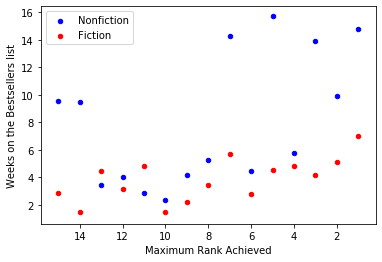

In [43]:
fig, ax = plt.subplots()
#Since a lower rank number means higher rank, we invert the x axis
plt.gca().invert_xaxis()
for index, table in nyt.groupby("Book_Type"):
    color = 'b'
    if index == 1:
        color = 'r'
    avg = table.groupby("max_rank").mean().reset_index()
    avg.plot(kind="scatter", x="max_rank", y="Weeks_On_List", ax = ax, color = color);
ax.legend(["Nonfiction","Fiction"]);
ax.set_xlabel("Maximum Rank Achieved");
ax.set_ylabel("Weeks on the Bestsellers list");

From this chart, we can see there is a slight positive correlation between weeks spent on the list and max rank, with nonfiction books having a more drastic increase than fiction books. If we make a linear regression on these two sets of points we can the following result:

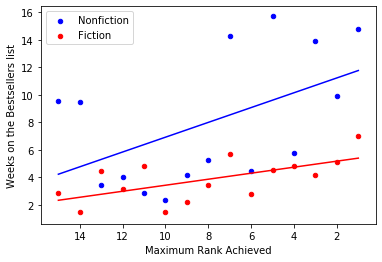

In [44]:
for index, table in nyt.groupby("Book_Type"):
    color = 'b'
    if index == 1:
        color = 'r'
    avg = table.groupby("max_rank").mean().reset_index()
    func = np.poly1d(np.polyfit(avg["max_rank"], avg["Weeks_On_List"],1))
    ax.plot(avg["max_rank"],func(avg["max_rank"]), c=color)
ax.figure

We can easily see that linear regression more accurately encompasses the fiction correlation, but shows that nonficiton books typically spend more time overall on the bestsellers list. What is important to note is that both see a positive correlation between high rank and number of weeks on the bestsellers list. This can likely be explain as books at a high rank spend a longer time "Working its way down" the list in rank until it is formally removed

## Genre Analysis

Unfortunately, the OpenLibrary API proved to be less than effective, only covering about half of what's on the bestsellers list we generated, nonetheless, that's still over 250 data points to examine, so we will trim the dataset to those with identified genres and examine the makeup of them. We will first generate a map containing all of the occurences of each book genre

In [45]:
nyt_g = nyt.dropna(subset=["genres"])
genre_map = {}

def add_genre(x):
    for i in x:
        try:
            genre_map[i] = genre_map[i]+1
        except KeyError:
            genre_map[i] = 1
            
nyt_g.apply(lambda x: add_genre(x["genres"]), axis=1)
genres = pd.DataFrame.from_dict(genre_map, orient="index").reset_index()
genres.columns =["Genre", "Count"]
genres = genres.sort_values(by="Count", ascending=False)
genres

,Genre,Count
24,Fiction,84
10,Biography,66
65,Politics and government,40
4,History,34
69,Presidents,22
...,...,...
333,Indians of North America,1
334,Powwows,1
335,FICTION / Political,1
336,Abandoned children,1


As we can see by the length of the DataFrame, Open Library maintains a very...specific palette of genres to choose from.

In [46]:
genres["Count"].describe()

count    745.000000
mean       1.852349
std        4.509214
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       84.000000
Name: Count, dtype: float64

Based on these summary statistics on genre frequency, it's apparent that there are a ton of niche genres that seemingly only appear for one book total, which provides little insight on the dataset as a whole, since a book can adopt multiple genres. For the sake of analysis, we will only keep genres with more than 5 occurences in our dataset.

In [47]:
genres = genres[genres["Count"] > 5]
genres

,Genre,Count
24,Fiction,84
10,Biography,66
65,Politics and government,40
4,History,34
69,Presidents,22
87,United States,17
118,Murder,13
119,Investigation,11
71,Election,8
67,Political culture,8


This specifies our data immensely. We can then plot the data in a bar plot

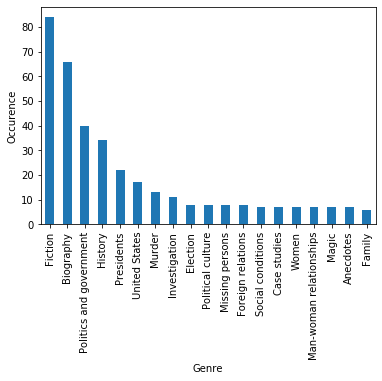

In [48]:
bar = genres.plot(kind="bar", x ="Genre", legend=None)
bar.set_ylabel("Occurence");

Based on this plot, it is apparent that, outside of general fiction, books that make the best seller list tend to be biographies and polticial books, dominating the top 5 genres in the list. One could conclude that this is due to people wanting to read about people and topics potentially relavent in their own lives.

One other thing we can examine is the average page length for a given genre. We can accomplish this with a simple modification for our frequency dictionary. We call an apply on the nyt_g dataframe and accumulate the total page number for each book in that genre

In [49]:
genre_pages = {}

def genre_count(x):
    for i in x["genres"]:
        try:
            genre_pages[i] = genre_pages[i]+x["page_count"]
        except KeyError:
            genre_pages[i] = x["page_count"]
            
nyt_g.apply(lambda x: genre_count(x), axis=1)
genres_total = pd.DataFrame.from_dict(genre_pages, orient="index").reset_index()
genres_total.columns =["genre", "page_count"]
genres_total = genres_total.sort_values(by="page_count", ascending=False)
genres_total = genres_total.dropna()
genres_total

,genre,page_count
64,Foreign relations,3281.0
71,Election,2870.0
32,Social conditions,2496.0
357,Intelligence officers,2357.0
288,Imaginary wars and battles,2230.0
...,...,...
448,Civics & Citizenship,126.0
444,Twentieth century,126.0
446,Despotism,126.0
441,Modern History,126.0


Note the reduced amount of "raw" genres compared to when we were only computing frequency. This is because OpenLibrary does not always have the page count for a book, even if it does have genre data.

If we examine some statistical data we see

In [50]:
genres_total.describe()

,page_count
count,563.000000
mean,512.786856
std,385.952730
min,126.000000
25%,300.500000
50%,368.000000
75%,578.000000
max,3281.000000


The page count data, like the mere frequency data, is heavily skewed, we can further examine this skew through a histogram

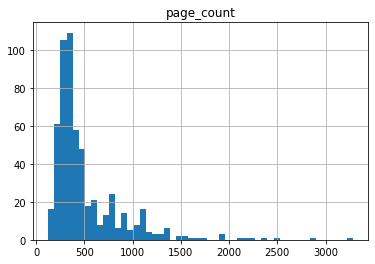

In [51]:
genres_total.hist(bins=50);

To see which genres are responsible for the highest page counts, we take a similar approach as before:

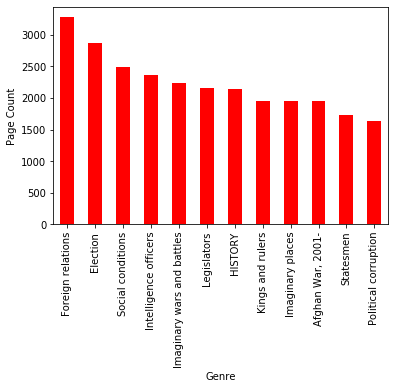

In [52]:
pc = genres_total[:12].plot(kind="bar",x="genre", legend=None, color='r');
pc.set_ylabel("Page Count");
pc.set_xlabel("Genre");

To little surprise New York Times bestselling books on politics, internation studies, and history contribute the highest page counts

# Part 4: Hypothesis Testing and ML

## The Prediction of Fiction!

Can we use logistic regression classification to see if a book, based on the number of weeks on the bestsellers list, the highest rank it achieved, and the number of ranks it held, is fiction or not? We will use the sklearn library to build a logistic regression model as well as to create testing and training data, and eventually measure the accuracy of the model

In [53]:
#Forming the column data into a 546x2 matrix
x = list(nyt.apply(lambda x: [len(x["Rank_List"]),x["max_rank"],x["Weeks_On_List"]], axis=1))
y = nyt["Book_Type"]
lr = LogisticRegression(solver='lbfgs')
#Retrieving x and y test data on a 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
lr.fit(x_train,y_train)
print("Model accuracy of "+str(lr.score(x_test,y_test)*100))

Model accuracy of 60.909090909090914


So, based on the results of this model, it can predict unseen data correctly with between 60-70% accuracy. In the words of a great Chernobyl Engineer: "Not great, not terrible"

## Genre prediction

If you were an aspiring New York Times Best Seller, wouldn't you want to know what genre of book to write to hit your target on the charts? Well given the data we have, we can use a random forest classifier to find out the exact genre to get you where you need to be!

Since our genre data comes in the form of an array, we want to extract the most 'popular' (frequently occuring) genre in that list and append a column to each row containing that specific genre. Luckily, we already have a dictionary containing that very information! All we do is select the genre with the highest frequency for each row

In [54]:
def extract_max(x):
    max_genre = x[0]
    for i in x:
        if genre_map[i] > genre_map[max_genre]:
            max_genre = i
    return max_genre

nyt_g = nyt_g.copy()
nyt_g["max_genre"] = nyt_g["genres"].map(extract_max)
nyt_g.head(5)

,Rank_List,Weeks_On_List,ISBN13,Publisher,Title,Author,Contributor,Dates,Book_Type,genres,publisher_location,page_count,OL_title,max_rank,max_genre
0,"[1, 2, 3, 9, 11, 15]",12,9780060899226,Ecco,KITCHEN CONFIDENTIAL,Anthony Bourdain,by Anthony Bourdain,"[2018-06-25, 2018-06-26, 2018-06-27, 2018-06-2...",0,"[Cooks, Accessible book, In library, Cocineros...",New York,312.0,Kitchen confidential,1,Biography
1,[6],1,9780061998065,HarperCollins,MEDIUM RAW,Anthony Bourdain,by Anthony Bourdain,"[2018-07-09, 2018-07-10, 2018-07-11, 2018-07-1...",0,"[nyt:paperback_nonfiction=2011-04-30, Nonficti...",New York,NaN,Medium Raw,6,Biography
2,"[3, 4, 5, 8, 11, 13, 14]",8,9780062294449,Harper,THE NEXT PERSON YOU MEET IN HEAVEN,Mitch Albom,by Mitch Albom,"[2018-10-22, 2018-10-23, 2018-10-24, 2018-10-2...",1,"[Amusement rides, Heaven, Older men, Death, Fu...",None,213.0,The next person you meet in Heaven,3,Fiction
4,"[3, 6, 11, 12, 13, 14, 15]",85,9780062300553,HarperCollins,HILLBILLY ELEGY,JD Vance,by J.D. Vance,"[2018-05-14, 2018-05-15, 2018-05-16, 2018-05-1...",0,"[Mountain people, Family, Social mobility, Wor...",None,288.0,Hillbilly Elegy,3,Biography
8,"[1, 2, 4, 5, 7, 9, 12, 14, 15]",15,9780062319784,Harper,I'LL BE GONE IN THE DARK,Michelle McNamara,by Michelle McNamara,"[2018-03-12, 2018-03-13, 2018-03-14, 2018-03-1...",0,"[Serial murders, Case studies, Serial murder i...",USA,352.0,I'll Be Gone in the Dark,1,Case studies


Now that we have a singular output designated for each book, we can now form a model to (attempt) to classify the kind of book it is. 

For the input, we want the publisher to be taken into account in the decision trees that are generated. Now, since this is a set of decision trees, it does not really matter if we use ordinal variables to differentiate between publishers, so we can set each publisher to a unique numeric value.

In [55]:
publishers = list(nyt_g.groupby("Publisher").groups.keys())
index = 0
publisher_value = {i: publishers.index(i) for i in publishers}

Now that a unqique id has been set for every publisher, we can include it in our training data

For this random forest, we will use a forest of 100 trees, with the number of weeks on list, highest rank, book type, and publisher will all be inputs, and the most popular genre will be the output

In [56]:
nyt_g = nyt_g.copy()
rf = RandomForestClassifier(n_estimators=100)
gx = list(nyt_g.apply(lambda x: [x["Weeks_On_List"], x["max_rank"], x["Book_Type"], \
                                 publisher_value[x["Publisher"]]],axis=1))
gy = nyt_g["max_genre"]
x_train, x_test, y_train, y_test = train_test_split(gx, gy, test_size=0.2)
rf.fit(x_train,y_train)
rf.score(x_test,y_test)*100

50.98039215686274

Well that accuracy isn't meaningless, but no better than a coin toss. Could results improve if, similar to our previous analysis, we only include more commonly assigned genres? 

In [57]:
nyt_pop_g = nyt_g.apply(lambda x: None if genre_map[x["max_genre"]] <= 5 else x, axis=1).dropna()
nyt_pop_g.head(5)

,Rank_List,Weeks_On_List,ISBN13,Publisher,Title,Author,Contributor,Dates,Book_Type,genres,publisher_location,page_count,OL_title,max_rank,max_genre
0,"[1, 2, 3, 9, 11, 15]",12.0,9780060899226,Ecco,KITCHEN CONFIDENTIAL,Anthony Bourdain,by Anthony Bourdain,"[2018-06-25, 2018-06-26, 2018-06-27, 2018-06-2...",0.0,"[Cooks, Accessible book, In library, Cocineros...",New York,312.0,Kitchen confidential,1.0,Biography
8,"[1, 2, 4, 5, 7, 9, 12, 14, 15]",15.0,9780062319784,Harper,I'LL BE GONE IN THE DARK,Michelle McNamara,by Michelle McNamara,"[2018-03-12, 2018-03-13, 2018-03-14, 2018-03-1...",0.0,"[Serial murders, Case studies, Serial murder i...",USA,352.0,I'll Be Gone in the Dark,1.0,Case studies
54,"[1, 2, 6, 7, 13]",5.0,9780062802187,Harper,FASCISM: A Warning,Madeleine Albright with Bill Woodward,by Madeleine Albright with Bill Woodward,"[2018-04-23, 2018-04-24, 2018-04-25, 2018-04-2...",0.0,"[Fascism, History]","New York, NY",288.0,Fascism,1.0,History
110,[15],2.0,9780316556330,"Little, Brown",CIRCE,Madeline Miller,by Madeline Miller,"[2018-07-09, 2018-07-10, 2018-07-11, 2018-07-1...",1.0,"[Fantasy, Mythology, Historical Fiction, Retel...","New York, USA",400.0,CIRCE,15.0,Fiction
128,"[3, 6, 7, 8, 9, 10, 14]",41.0,9780385534246,Doubleday,KILLERS OF THE FLOWER MOON,David Grann,by David Grann,"[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...",0.0,"[Case studies, United States. Federal Bureau o...",New York,338.0,Killers of the Flower Moon,3.0,History


Now that we narrowed our options to things a little more consistent, we can repeat the above steps and rebuild our random forest

In [94]:
rfpop = RandomForestClassifier(n_estimators=100)
gx1 = list(nyt_pop_g.apply(lambda x: [x["Weeks_On_List"], x["max_rank"], x["Book_Type"], \
                                 publisher_value[x["Publisher"]]],axis=1))
gy1 = nyt_pop_g["max_genre"]
x_train, x_test, y_train, y_test = train_test_split(gx1, gy1, test_size=0.2)
rfpop.fit(x_train,y_train)
rfpop.score(x_test,y_test)*100

75.0

By eliminating niche genres, we were able to bump our accuracy reading by >10%! Not bad!